In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy



from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve

import time

# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
             "log_probability_2flares2ars": 10 # two flares, two active regions
            }



# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
tstamp

'20_08_2020_16_21'

In [4]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 2
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
GRP                        1.54
plxmas                  90.0357
eplxmas                0.222697
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms               34.8422
e_vsini_kms                   3
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar   

In [16]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.9) & (t < target.view_stop-.1) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


KIC 100004076 modulation period:  8.877023313700208 h
Relative amplitude of modulation: 6.4e-03


Text(0, 0.5, 'flux [e$^{-}$/s]')

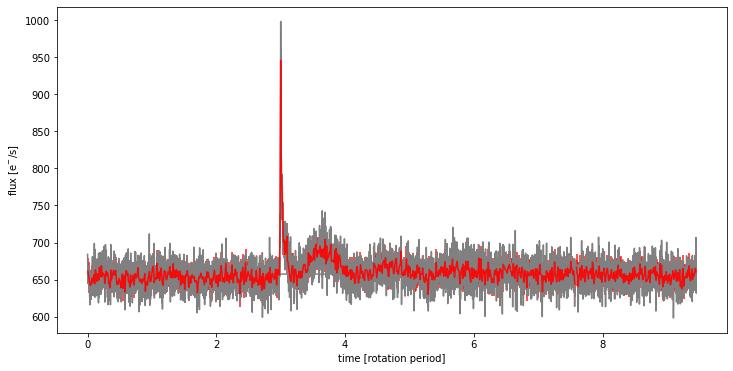

In [17]:

cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.figure(figsize=(12,6))
plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="grey")
plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]")
#plt.xlim(25,30)

In [18]:
#cff = cff[(cff.phi<18.7) |(cff.phi>19.6)]
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.0594, 0.066]",0.028903,661.438301,1357.401912,17.692244,657.472073
"(0.066, 0.132]",0.098272,655.882679,1357.405999,17.692244,657.472073
"(0.132, 0.198]",0.167641,649.177418,1357.410085,17.692244,657.472073
"(0.198, 0.264]",0.231229,643.231956,1357.413831,17.692244,657.472073
"(0.264, 0.33]",0.294818,642.154388,1357.417578,17.692244,657.472073
...,...,...,...,...,...
"(59.073, 59.139]",59.108074,658.151060,1360.882337,17.692244,657.472073
"(59.139, 59.205]",59.171662,654.798674,1360.886083,17.692244,657.472073
"(59.205, 59.271]",59.235250,658.524767,1360.889829,17.692244,657.472073


In [19]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [20]:
tstamp

'18_08_2020_15_42'

(608.0, 900.0)

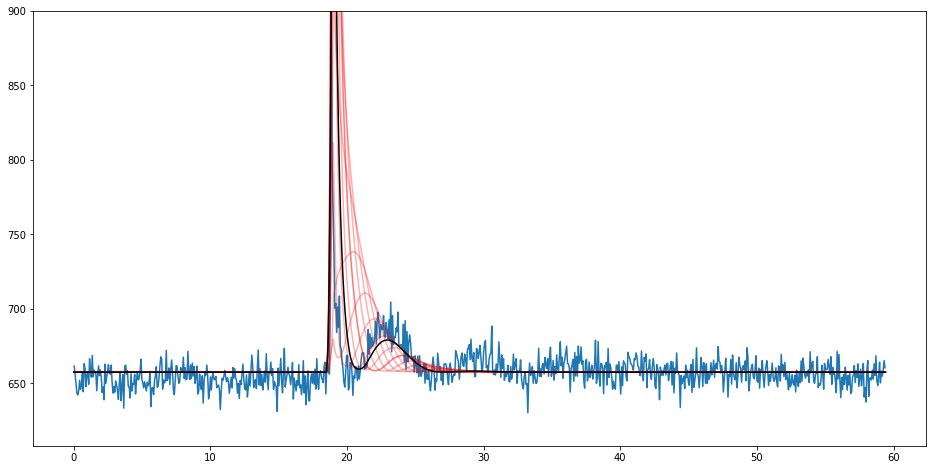

In [31]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =19

# Active region latitude
theta_a = 1.

# Flare amplitude
a = 1.4

# 2*FWHM of flare
fwhm =  1.


phi0 =5.1
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(cff.phi,cff.flux)
for i in np.linspace(-2*np.pi,2*np.pi,10):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,);
# plt.xlim(1331,1333.25)
plt.ylim(608,900)

In [32]:
# Choose model:
log_prob = "log_probability"#_2flares"#2ars"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)